# Neural Networks and Deep Learning

## Homework 3 - Reinforcement Learning

### Academic Year 2021/2022 
### Dr. Alberto Testolin, Dr. Umberto Michieli

### Capettini Croatto Hilario

The first section of this notebook is shared by all the reinforcement learning tasks, then in this notebook I treat the basic cartpole we studied in lab 7.

# Deep Reinforcement Learning

**Write a nice intro to the topic**

In [1]:
### IMPORTS
import random
import numpy as np
import matplotlib.pyplot as plt
import tqdm 
from collections import deque # Python module useful for replay memory

import torch
from torch import nn
import gym
from IPython.display import clear_output

# For GIFS production
from PIL import Image
from IPython.display import Image as Gif_disp

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Experience replay 
"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

In [2]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        """Define a queue with maxlen capacity"""
        self.memory = deque(maxlen=capacity) 
    
    def push(self, state, action, next_state, reward):
        """Add the tuple (state, action, next_state, reward) to the queue"""
        self.memory.append((state, action, next_state, reward))
        
    def sample(self, batch_size):
        """randomly select batch_size samples"""
        batch_size = min(batch_size, len(self))
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Return the number of samples currently stored in memory"""
        return len(self.memory)
    

## Policy network

The policy network takes a **state** as input, and provides the Q-value for each of the possible **actions**.

In [3]:
class DQN(nn.Module):
    
    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()
        
        self.linear = nn.Sequential(
            nn.Linear(in_features=state_space_dim, out_features=128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=128),
            nn.Tanh(),
            nn.Linear(in_features=128, out_features=action_space_dim)
                )
        
    def forward(self,x):
        return self.linear(x)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (**exploitation**), or maybe we want to find a better policy by choosing a different action (**exploration**).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy

In [4]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

In [5]:
def choose_action_softmax(net, state, temperature):
    """With a softmax policy we choose the action based on a distribution obtained
       applying a softmax (with temperature  τ ) to the estimated Q-values. The highest
       the temperature, the more the distribution will converge to a random uniform 
       distribution. At zero temperature, instead, the policy will always choose the
       action with the highest Q-value."""
    
    if temperature < 0:
        raise Exeption("The temperature value must be greater or equal to 0")
    
    # Evaluate the network output from current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)    
    
    # If temperature is 0, just select the best action
    if temperature == 0:
        return int(net_out.argmax()) , net_out.numpy()
             
    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # Set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim = 0).numpy()
    
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p = softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

## Network update


### Update function

In [6]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
    """Makes a pass over a randomly sampled batch of the replay memory and update the network accordingly"""
    # Sample the data from replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    
    # Create tensors for each element of the batch
    states  = torch.tensor(np.array([s[0] for s in batch]),dtype = torch.float32)
    actions = torch.tensor(np.array([s[1] for s in batch]),dtype = torch.int64)
    rewards = torch.tensor(np.array([s[3] for s in batch]),dtype = torch.float32)
    
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor(np.array([s[2] for s in batch if s[2] is not None]), dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor(np.array([s[2] is not None for s in batch]), dtype=torch.bool)
    
    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))
    
    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    
    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

### training Loop

In [7]:
def initialization(param,state_space_dim,action_space_dim):
    """ This function initializes the different components of the reinforcement learning system
        (replay memory, networks) and also the optimizer and loss function"""
    ### Initialize the replay memory
    replay_mem = ReplayMemory(param["replay_memory_capacity"])

    ### Initialize the policy network
    policy_net = DQN(state_space_dim,action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=param["lr"]) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [25]:
def training(policy_net, target_net, replay_mem, optimizer, loss_fn,action_chooser, exploration_profile, env,
              param, verbose=True,reward_fn="original"):
    """ Training loop.
        To save time I implement a early stop if in the last 50 iterations the game
        was properly solved."""

    final_score = []
    counter = 0     #Counter for early stop purpose
    for episode_num, tau in enumerate(tqdm.tqdm(exploration_profile)):
        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = action_chooser(policy_net, state, tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # MODIFY REWARD FUNCTION
            if reward_fn == "tweaked":
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 1
                reward = reward - pos_weight * np.abs(state[0]) 
            
            elif reward_fn =="original":
                pos_weight = 1
                reward = reward - pos_weight * np.abs(state[0])
            
            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += param["bad_state_penalty"]
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > param["min_samples_for_training"]: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, param["gamma"], optimizer, loss_fn, param["batch_size"])

            # Visually render the environment (disable to speed up the training)
            # WRITE SOME CODE TO SAVE THE IMAGES FOR GIFS

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % param["target_net_update_steps"] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose:
            print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        final_score.append(score)
        # Early Stop
        if final_score[-1]>=500: 
            counter +=1
        else:
            counter = 0
        if counter >=50:
            print("EARLY STOP: 50 continuous iterations reached the solution.")
            break 
    env.close()
    return final_score,policy_net

### Functions for visualization

In [9]:
def moving_average(x, w):
    """It estimates the moving average of a serie using a window of size w"""
    return np.convolve(x, np.ones(w), 'valid') / w

In [10]:
def plot_results(score,exploration_profile,title="",file_name="./Images/",yr_name="Temperature"):
    fig, ax = plt.subplots(figsize=(7,5))
    ax2 = ax.twinx()

    ax.plot(score, color='slategrey')
    ax.plot(moving_average(score, 50), color='navy')
    ax.axhline(y = 500, color = 'green', linestyle = '--')
    ax.set_ylim(0,650)
    ax.set_ylabel('Score',fontsize=15)
    ax.legend(["Episodes score","Moving average of scores", "Game Solved" ], loc='upper right')

    ax2.plot(exploration_profile, color='red')
    ax2.legend([yr_name], loc='upper left')
    ax2.set_ylabel(yr_name,fontsize=15)

    ax.set_xlabel('Episode',fontsize=15)
    ax.set_title(title,fontsize=15)

    #plt.legend()
    plt.tight_layout()
    plt.savefig(file_name, format='svg')
    plt.show()

In [11]:
def test_function(environment,policy,get_gif=False,gif_name ="",verbose=True):
    """If get_frames is true then we recover a list with PIL images one for each survival frame"""
    state = environment.reset()
    score = 0
    survival_time = 0
    frames = []
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        if get_gif: frames.append(Image.fromarray(environment.render(mode="rgb_array")))
        action, q_values = choose_action_softmax(policy, state, temperature=0) # Choose the best action (temperature 0)
        next_state, reward, done, info = environment.step(action)              # Apply the action
        score += reward                                                        # Update scores
        state = next_state                                                     # Set the current state for the next iteration
        survival_time +=1
    if verbose: print(f"FINAL SCORE: {score}, SURVIVAL TIME: {survival_time}") 
    if get_gif: gif_creator(frames,f"./Images/{gif_name}.gif")

In [12]:
def gif_creator(image_list,name):
    return image_list[0].save(name,save_all=True, append_images=image_list[1:], duration=50, loop=0)

# Cartpole Task

**3 pt - Use the notebook of Lab 07 to study how the exploration profile (either using eps-greedy or softmax) impacts the learning curve. Tune a bit the model hyperparameters or tweak the reward function to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).**

## Study on the exploration profiles

In [13]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Softmax

We define three different exploration profiles to study the impact on the learning process, in particular to see how the extremes of exploration and exploitation behave.

In [14]:
### Define exploration profile for SOFTMAX policy
initial_value = 5
num_iterations = 500

exploration_profiles = []
slopes = [2,5,10]
for slope in slopes:
    # We compute the exponential decay in such a way the shape of
    # the exploration profile does not depend on the number of iterations
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * slope)
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    exploration_profiles.append(exploration_profile)


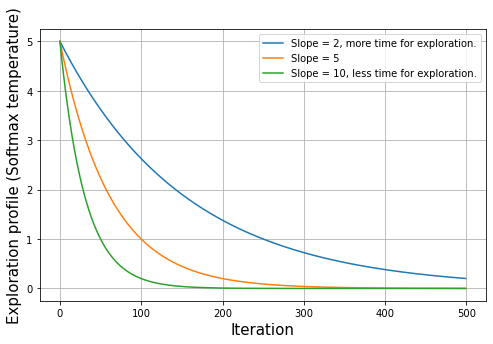

In [15]:
### Plot exploration profile
plt.figure(figsize=(8,5))
plt.plot(exploration_profiles[0], label = f"Slope = {slopes[0]}, more time for exploration.")
plt.plot(exploration_profiles[1], label = f"Slope = {slopes[1]}")
plt.plot(exploration_profiles[2], label = f"Slope = {slopes[2]}, less time for exploration.")
plt.legend()
plt.grid()
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('Exploration profile (Softmax temperature)',fontsize=15)
plt.savefig('./Images/cartpole/exploration_profiles.svg', format='svg')
plt.show()

**Training**

In [16]:
### Create environment
# Initialize the Gym environment
env = gym.make("CartPole-v1")
env.reset(seed=0)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim  = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [17]:
parameters = {"gamma":                    0.97,
              "batch_size":               128,
              "bad_state_penalty":        0,
              "min_samples_for_training": 1000,
              "target_net_update_steps":  10,
              "lr":                       1e-2,
              "replay_memory_capacity":   10000
              }

scores_by_profile = []
for exploration_profile in exploration_profiles:
    ### Initialize the components
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialization(parameters,state_space_dim,action_space_dim)
    ### select an exploration policy
    exploration_policy = choose_action_softmax
    ### Train the network
    score, network = training(policy_net, target_net, replay_mem, optimizer, loss_fn,exploration_policy, exploration_profile, env,
                     parameters, verbose=False)
    
    scores_by_profile.append(score)

100%|██████████| 500/500 [06:01<00:00,  1.38it/s]


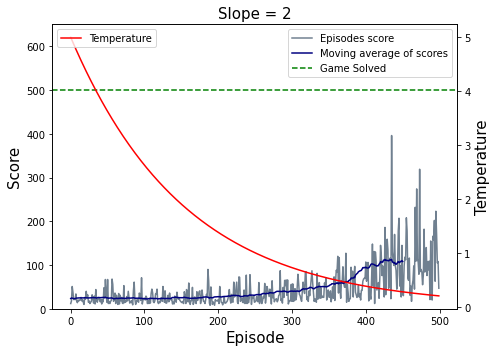

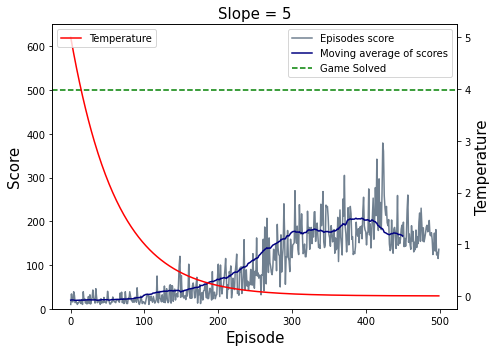

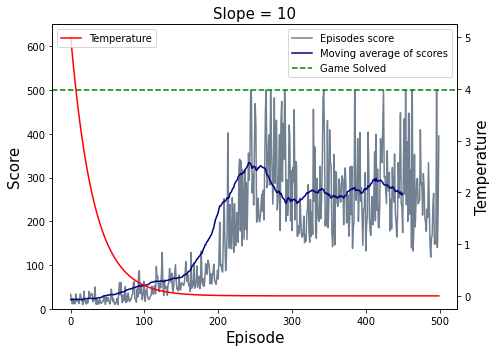

In [18]:
plot_results(scores_by_profile[0],exploration_profiles[0],f"Slope = {slopes[0]}",f'./Images/cartpole/cartpole_prof_expl_soft_{slopes[0]}.svg')
plot_results(scores_by_profile[1],exploration_profiles[1],f"Slope = {slopes[1]}",f'./Images/cartpole/cartpole_prof_expl_soft_{slopes[1]}.svg')
plot_results(scores_by_profile[2],exploration_profiles[2],f"Slope = {slopes[2]}",f'./Images/cartpole/cartpole_prof_expl_soft_{slopes[2]}.svg')

### Epsilon-greedy

We define three different exploration profiles to study the impact on the learning process, in particular to see how the extremes of exploration and exploitation behave.

In [19]:
### Remember to keep the epsilon values between 0 and 1.
exploration_profiles = []
exploration_profiles.append([i for i in np.concatenate((np.full(50, 1.),np.full(75, 0.7),np.full(100, 0.5),np.full(175, 0.)))])
exploration_profiles.append([i for i in np.concatenate((np.full(50, 1.),np.full(75, 0.5),np.full(100, 0.3),np.full(175, 0.)))])
exploration_profiles.append([i for i in np.concatenate((np.full(50, 1.),np.full(75, 0.3),np.full(100, 0.1),np.full(175, 0.)))])

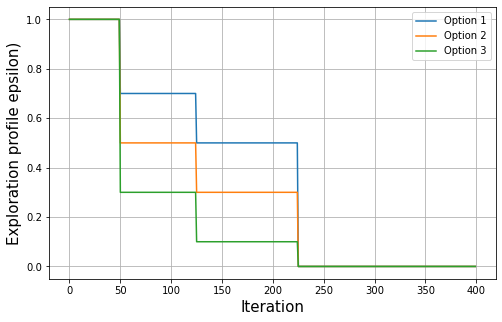

In [20]:
### Plot exploration profile
plt.figure(figsize=(8,5))
plt.plot(exploration_profiles[0], label = f"Option 1")
plt.plot(exploration_profiles[1], label = f"Option 2")
plt.plot(exploration_profiles[2], label = f"Option 3")
plt.legend()
plt.grid()
plt.xlabel('Iteration',fontsize=15)
plt.ylabel('Exploration profile epsilon)',fontsize=15)
plt.savefig('./Images/cartpole/exploration_profiles_epsilon.svg', format='svg')
plt.show()

**Training**

In [21]:
parameters = {"gamma":                    0.97,
              "batch_size":               128,
              "bad_state_penalty":        0,
              "min_samples_for_training": 1000,
              "target_net_update_steps":  10,
              "lr":                       1e-2,
              "replay_memory_capacity":   10000
              }

scores_by_profile = []
for exploration_profile in exploration_profiles:
    ### Initialize the components
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialization(parameters,state_space_dim,action_space_dim)
    ### select an exploration policy
    exploration_policy = choose_action_epsilon_greedy
    ### Train the network
    score, network = training(policy_net, target_net, replay_mem, optimizer, loss_fn,exploration_policy, exploration_profile, env,
                     parameters, verbose=False)
    
    scores_by_profile.append(score)

100%|██████████| 400/400 [01:24<00:00,  4.73it/s]


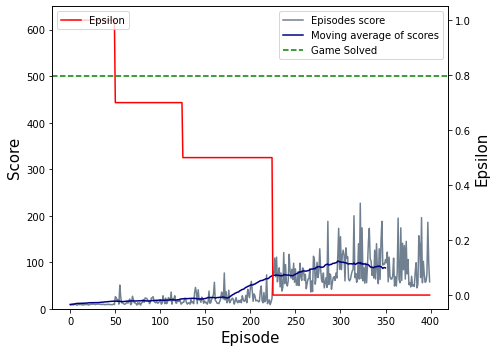

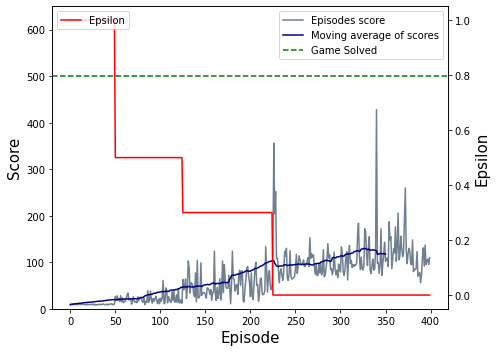

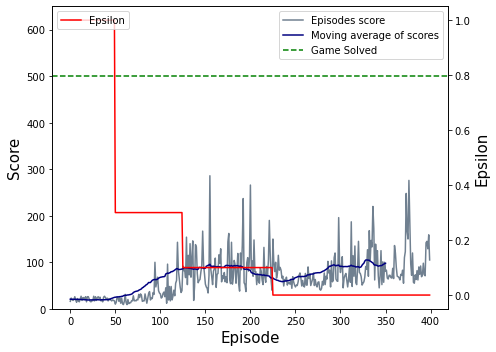

In [22]:
plot_results(scores_by_profile[0],exploration_profiles[0],"",f'./Images/cartpole/cartpole_prof_expl_eps_0.svg',yr_name="Epsilon")
plot_results(scores_by_profile[1],exploration_profiles[1],"",f'./Images/cartpole/cartpole_prof_expl_eps_1.svg',yr_name="Epsilon")
plot_results(scores_by_profile[2],exploration_profiles[2],"",f'./Images/cartpole/cartpole_prof_expl_eps_2.svg',yr_name="Epsilon")

## Study on model hyperparameters

As the task is considerably time consuming I decided to optimize only a selected group of parameters using a random search.
Gamma has a a huge impact in terms of the importance we give to past moves, which I consider useful for this task. Also the learning rate is an important parameter.

In [26]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [27]:
### Create environment
# Initialize the Gym environment
env = gym.make("CartPole-v1")
env.reset(seed=0)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim  = env.observation_space.shape[0]
action_space_dim = env.action_space.n

In [28]:
n_tests = 20
num_iterations = 1000

# Parameters to modify
gamma_options = np.linspace(0.9, 0.99, 20)
lr_options    = np.logspace(-3, -1, 10)

# Lists to save results
used_parameters = []
scores_by_parameters = []
exploration_profiles = []
used_slopes = []
for i in range(n_tests):
    print(f"Iteration {i}")
    ### Exploration profile
    initial_value = 5
    slope         =  5
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * slope)
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    
    ### PARAMETERS
    parameters = {"gamma":                    np.random.choice(gamma_options),
                  "batch_size":               128,
                  "bad_state_penalty":        0,
                  "min_samples_for_training": 1000,
                  "target_net_update_steps":  10,
                  "lr":                       np.random.choice(lr_options),
                  "replay_memory_capacity":   10000
                  }


    ### Initialize the components
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialization(parameters,state_space_dim,action_space_dim)
    ### select an exploration policy
    exploration_policy = choose_action_softmax
    ### Train the network    
    score, net = training(policy_net, target_net, replay_mem, optimizer, loss_fn,exploration_policy, exploration_profile, env,
                         parameters, verbose=False)
    
    used_parameters.append(parameters)
    scores_by_parameters.append(score)
    exploration_profiles.append(exploration_profile)
    used_slopes.append(slope)    


Iteration 0


100%|██████████| 1000/1000 [07:06<00:00,  2.34it/s]


Iteration 1


100%|██████████| 1000/1000 [04:03<00:00,  4.11it/s]


Iteration 2


100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]


Iteration 3


100%|██████████| 1000/1000 [04:11<00:00,  3.98it/s]


Iteration 4


100%|██████████| 1000/1000 [14:45<00:00,  1.13it/s]


Iteration 5


 74%|███████▍  | 744/1000 [06:58<02:24,  1.78it/s]


EARLY STOP: 50 continuous iterations reached the solution.
Iteration 6


 65%|██████▍   | 647/1000 [07:04<03:51,  1.52it/s]


EARLY STOP: 50 continuous iterations reached the solution.
Iteration 7


100%|██████████| 1000/1000 [08:46<00:00,  1.90it/s]


Iteration 8


100%|██████████| 1000/1000 [05:09<00:00,  3.24it/s]


Iteration 9


100%|██████████| 1000/1000 [06:58<00:00,  2.39it/s]


Iteration 10


 84%|████████▍ | 840/1000 [10:43<02:02,  1.31it/s]


EARLY STOP: 50 continuous iterations reached the solution.
Iteration 11


100%|██████████| 1000/1000 [05:07<00:00,  3.26it/s]


Iteration 12


100%|██████████| 1000/1000 [03:18<00:00,  5.05it/s]


Iteration 13


 96%|█████████▌| 960/1000 [11:13<00:28,  1.43it/s]


EARLY STOP: 50 continuous iterations reached the solution.
Iteration 14


100%|██████████| 1000/1000 [04:08<00:00,  4.03it/s]


Iteration 15


100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


Iteration 16


100%|██████████| 1000/1000 [05:57<00:00,  2.80it/s]


Iteration 17


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


Iteration 18


100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]


Iteration 19


100%|██████████| 1000/1000 [05:49<00:00,  2.86it/s]


{'gamma': 0.9568421052631579, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.01291549665014884, 'replay_memory_capacity': 10000}


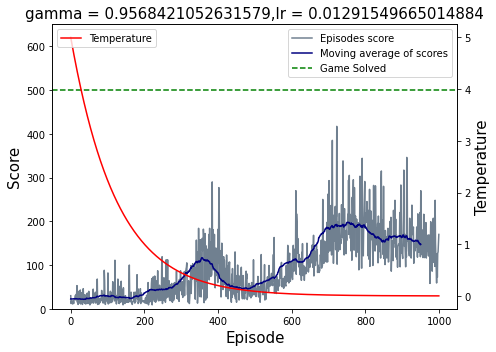

{'gamma': 0.9710526315789474, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.0027825594022071257, 'replay_memory_capacity': 10000}


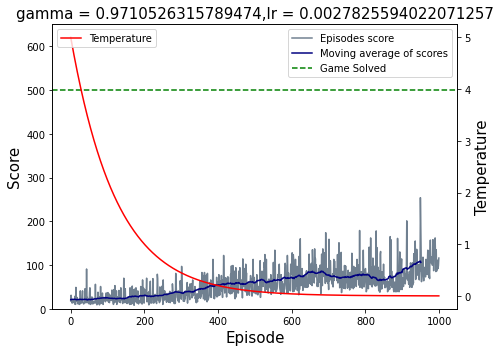

{'gamma': 0.9805263157894737, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.0016681005372000592, 'replay_memory_capacity': 10000}


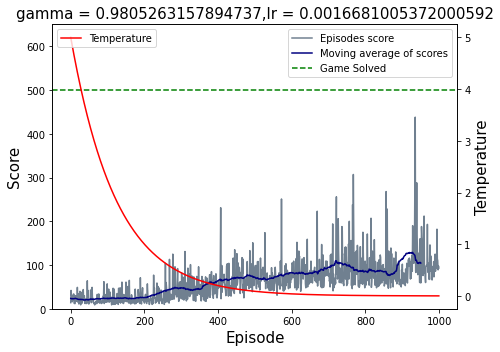

{'gamma': 0.9047368421052632, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.0027825594022071257, 'replay_memory_capacity': 10000}


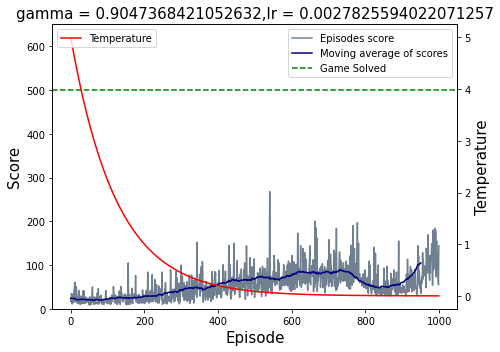

{'gamma': 0.9426315789473685, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.05994842503189409, 'replay_memory_capacity': 10000}


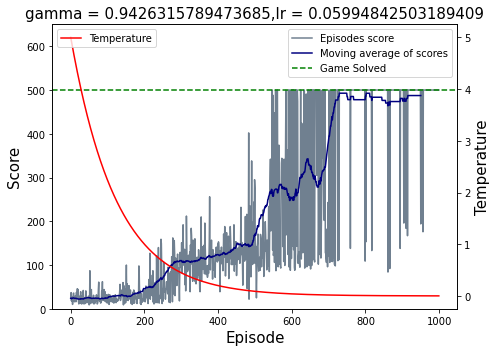

{'gamma': 0.99, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.01291549665014884, 'replay_memory_capacity': 10000}


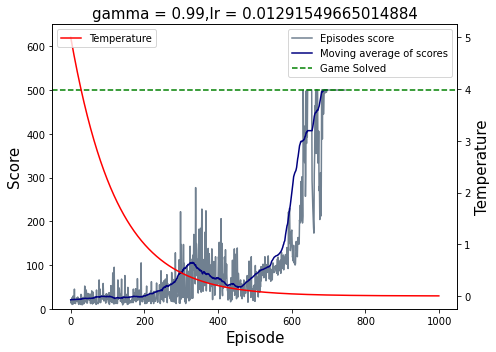

{'gamma': 0.9805263157894737, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.021544346900318832, 'replay_memory_capacity': 10000}


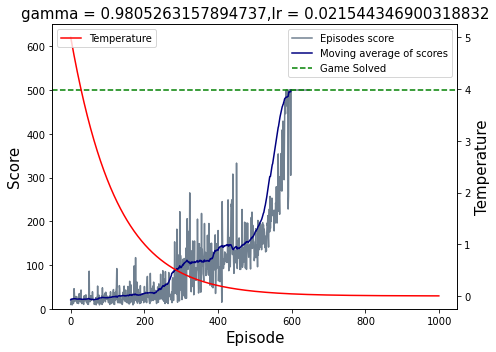

{'gamma': 0.9473684210526316, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.01291549665014884, 'replay_memory_capacity': 10000}


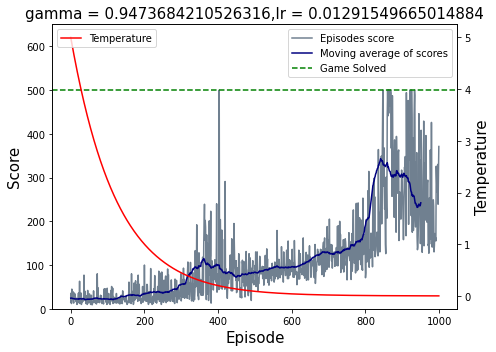

{'gamma': 0.9236842105263158, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.007742636826811269, 'replay_memory_capacity': 10000}


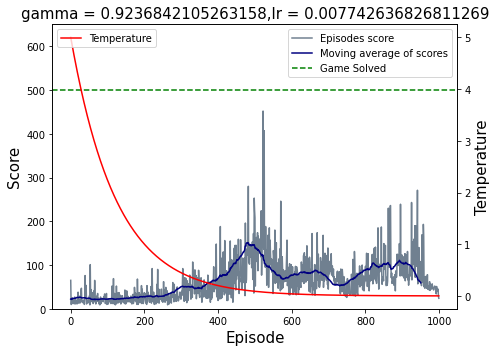

{'gamma': 0.9378947368421052, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.05994842503189409, 'replay_memory_capacity': 10000}


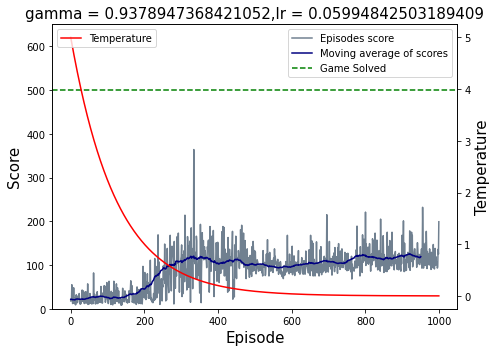

{'gamma': 0.9473684210526316, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.03593813663804626, 'replay_memory_capacity': 10000}


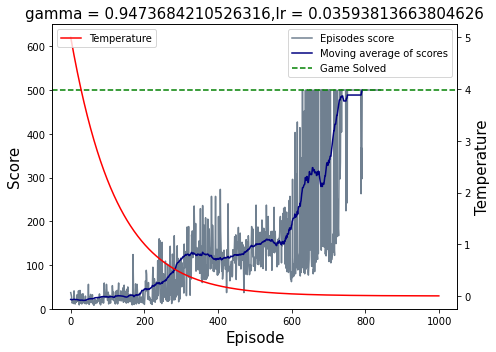

{'gamma': 0.9521052631578948, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.004641588833612777, 'replay_memory_capacity': 10000}


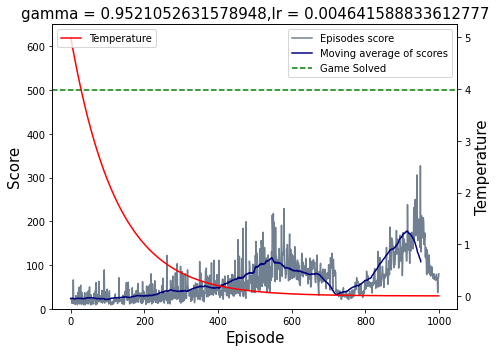

{'gamma': 0.9852631578947368, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.001, 'replay_memory_capacity': 10000}


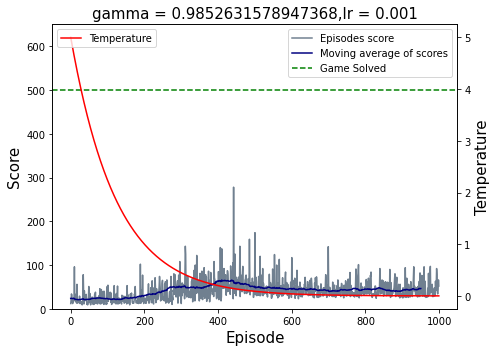

{'gamma': 0.9473684210526316, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.021544346900318832, 'replay_memory_capacity': 10000}


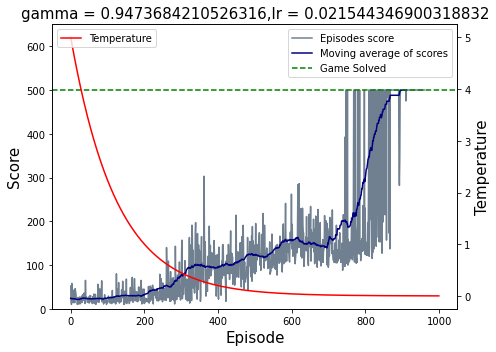

{'gamma': 0.9426315789473685, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.001, 'replay_memory_capacity': 10000}


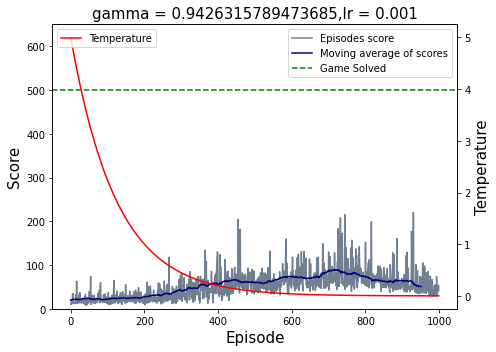

{'gamma': 0.9047368421052632, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.05994842503189409, 'replay_memory_capacity': 10000}


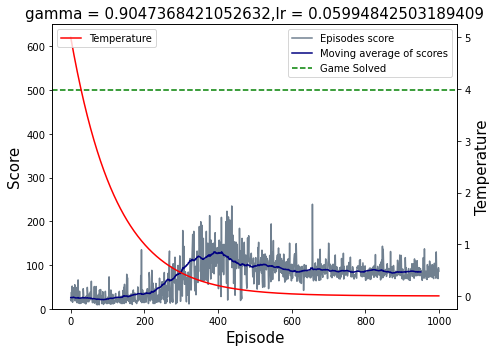

{'gamma': 0.9094736842105263, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.05994842503189409, 'replay_memory_capacity': 10000}


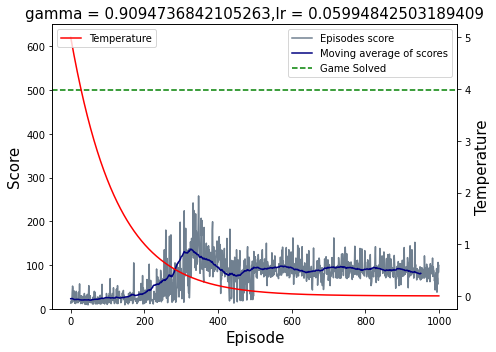

{'gamma': 0.9521052631578948, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.0027825594022071257, 'replay_memory_capacity': 10000}


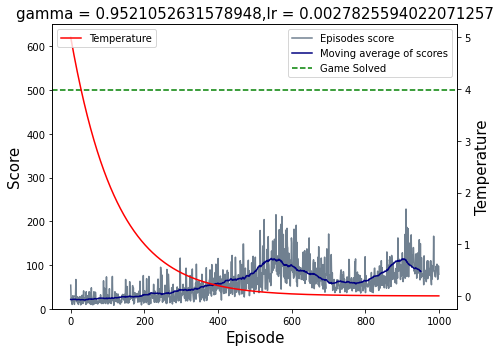

{'gamma': 0.9568421052631579, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.004641588833612777, 'replay_memory_capacity': 10000}


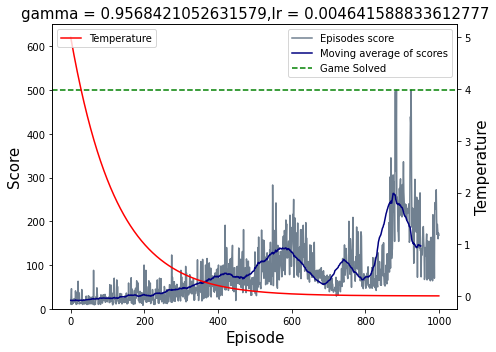

{'gamma': 0.9284210526315789, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.01291549665014884, 'replay_memory_capacity': 10000}


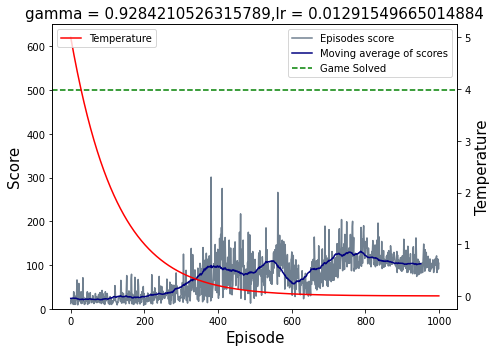

In [30]:
for i in range(len(scores_by_parameters)):
    print(used_parameters[i])
    g_ =used_parameters[i]['gamma'] 
    l_ =used_parameters[i]['lr']
    plot_results(scores_by_parameters[i],exploration_profiles[i],
                 f"gamma = {g_},lr = {l_}",
                 f'./Images/cartpole/cartpole_hyp_{i}.svg')


### Test on Best model
Now I will re train the best model for 1000 iterations and use the learned network to play the game.

In [31]:
#From direct observation of the plots the best model seems to be
best_model = 6
print(used_parameters[best_model])
print(used_slopes[best_model])

{'gamma': 0.9805263157894737, 'batch_size': 128, 'bad_state_penalty': 0, 'min_samples_for_training': 1000, 'target_net_update_steps': 10, 'lr': 0.021544346900318832, 'replay_memory_capacity': 10000}
5


In [34]:
# Lists to save results
scores = []
exploration_profile = exploration_profiles[best_model]
    
### PARAMETERS
parameters = {"gamma":                    used_parameters[best_model]["gamma"],
                  "batch_size":               128,
                  "bad_state_penalty":        0,
                  "min_samples_for_training": 1000,
                  "target_net_update_steps":  10,
                  "lr":                       used_parameters[best_model]["lr"],
                  "replay_memory_capacity":   10000
                  }


### Initialize the components
replay_mem, policy_net, target_net, optimizer, loss_fn = initialization(parameters,state_space_dim,action_space_dim)
### select an exploration policy
exploration_policy = choose_action_softmax
### Train the network    
score, policy = training(policy_net, target_net, replay_mem, optimizer, loss_fn,exploration_policy, exploration_profile, env,
                         parameters, verbose=False)
    

 71%|███████   | 707/1000 [05:55<02:27,  1.99it/s]

EARLY STOP: 50 continuous iterations reached the solution.


In [35]:
# Save the best policy network
torch.save(policy.state_dict(),'./Best_Models/best_policy_net_cartpole.pth')


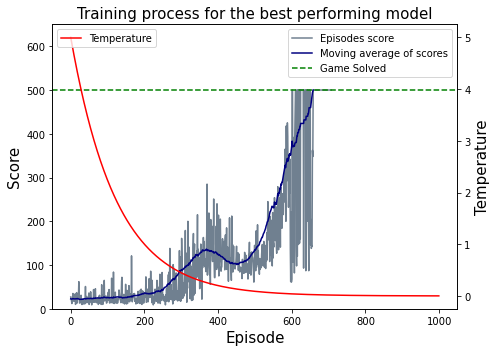

In [36]:
plot_results(score,exploration_profiles[0],f"Training process for the best performing model",
                 f'./Images/cartpole/cartpole_best.svg')


### Test

In [37]:
# Load the best model
policy_net = DQN(state_space_dim,action_space_dim)
policy_net.load_state_dict(torch.load('./Best_Models/best_policy_net_cartpole.pth'))


<All keys matched successfully>

In [38]:
# Initialize the Gym environment
CartPole_env = gym.make('CartPole-v1')
CartPole_env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 5 episodes
for num_episode in range(5): 
    test_function(CartPole_env,policy_net,get_gif=True,gif_name=f"Pole_Gifs/Trained_Pole_{num_episode}") 
CartPole_env.close()

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\gym\core.py:51: DeprecationWarning: WARN: The argument m

FINAL SCORE: 500.0, SURVIVAL TIME: 500
FINAL SCORE: 500.0, SURVIVAL TIME: 500
FINAL SCORE: 500.0, SURVIVAL TIME: 500
FINAL SCORE: 500.0, SURVIVAL TIME: 500
FINAL SCORE: 500.0, SURVIVAL TIME: 500


In [1]:
from IPython.display import Image as Gif_disp

In [2]:
#Gif_disp(url="./Images/Pole_Gifs/Trained_Pole_0.gif")
Gif_disp(url="./Trained_Pole_0.gif")